# High-Speed Fuse Break Analysis

Ce notebook analyse des vidéos de radiographie à rayons X à haute vitesse de fusibles industriels pour mesurer la distance entre les éléments du fusible pendant les événements de rupture.

## Aperçu

Les fusibles à haute capacité de rupture (HRC) sont des composants de sécurité essentiels dans les systèmes électriques. Lorsqu'un court-circuit se produit, ces fusibles doivent se rompre rapidement pour protéger le circuit. Ce notebook analyse les vidéos de radiographie à rayons X des événements de rupture de fusibles pour mesurer la distance entre les éléments du fusible au fil du temps, fournissant des informations sur la dynamique de rupture.

## 1. Importation des bibliothèques

In [35]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
import pandas as pd
import time
import logging
from scipy.signal import savgol_filter
from skimage import measure

# Importer notre module d'analyse de fusibles
from fuse_analysis import VideoProcessor, FuseImageProcessor, FuseAnalysisVisualizer

# Configuration du logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)


## 2. Chargement et prétraitement de la vidéo

In [36]:
# Définir les chemins
video_path = '../data/Camera_15_04_58.mp4'
output_dir = '../results/notebook_results'
os.makedirs(output_dir, exist_ok=True)

# Initialiser les composants
video_processor = VideoProcessor(video_path)
image_processor = FuseImageProcessor(calibration_value_mm=2.0)
visualizer = FuseAnalysisVisualizer(output_dir)

# Charger la vidéo et extraire les frames
frames = video_processor.extract_all_frames()

# Afficher quelques informations sur la vidéo
print(f"Nombre de frames: {len(frames)}")
print(f"Dimensions: {video_processor.width}x{video_processor.height}")
print(f"FPS: {video_processor.fps}")

Video loaded: 400x250, 7.0 fps, 128 frames
Extracted 128 frames
Nombre de frames: 128
Dimensions: 400x250
FPS: 7.0


## 3. Calibration du système de mesure

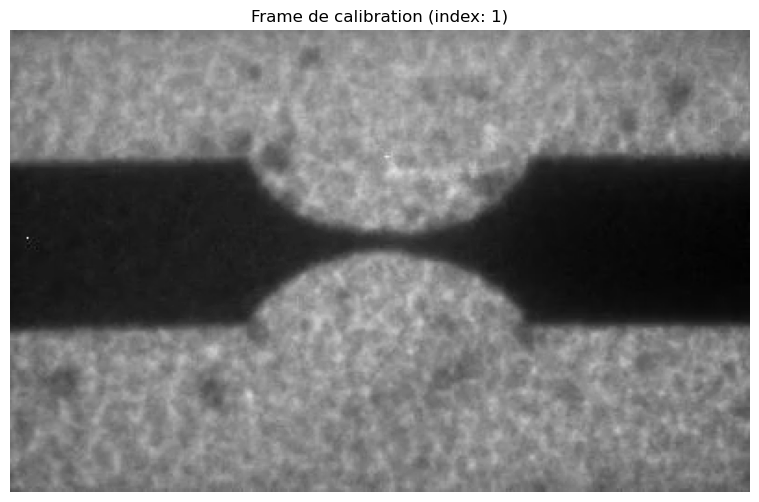

Calibration complete: 49.00 pixels/mm
Facteur de calibration: 49.00 pixels/mm


In [37]:
# Utiliser la première frame pour la calibration
calibration_frame_idx = 1
calibration_frame = frames[calibration_frame_idx].data

# Afficher la frame de calibration
plt.figure(figsize=(10, 6))
plt.imshow(calibration_frame, cmap='gray')
plt.title(f"Frame de calibration (index: {calibration_frame_idx})")
plt.axis('off')
plt.show()

# Effectuer la calibration
pixels_per_mm = image_processor.calibrate(calibration_frame)
print(f"Facteur de calibration: {pixels_per_mm:.2f} pixels/mm")

## 4. Mesure de la distance entre les éléments du fusible

In [38]:
# Mesurer la distance pour chaque frame
frame_indices = []
distances = []
processed_frames = []

for i, frame in enumerate(frames):
    try:
        distance = image_processor.measure_distance(frame.data)
        if distance is not None:
            frame_indices.append(i)
            distances.append(distance)
            
            # Créer une visualisation
            vis_frame = image_processor.visualize_measurement(frame.data, distance)
            processed_frames.append(vis_frame)
    except Exception as e:
        print(f"Erreur lors du traitement de la frame {i}: {str(e)}")

print(f"Nombre de mesures réussies: {len(distances)}")

Nombre de mesures réussies: 128


## 5. Lissage des mesures de distance

In [39]:
# Appliquer un lissage aux mesures de distance
if len(distances) > 5:
    # Utiliser le filtre Savitzky-Golay pour le lissage
    window_size = min(15, len(distances) - (len(distances) % 2 == 0))
    if window_size % 2 == 0:
        window_size -= 1
    if window_size >= 5:  # Taille minimale de fenêtre pour le filtre
        try:
            smoothed_distances = savgol_filter(distances, window_size, 3)
            print(f"Lissage appliqué avec une fenêtre de taille {window_size}")
        except Exception as e:
            print(f"Échec du lissage: {str(e)}. Utilisation des données originales.")
            smoothed_distances = distances
    else:
        smoothed_distances = distances
        print("Pas assez de points pour appliquer un lissage efficace")
else:
    smoothed_distances = distances
    print("Pas assez de points pour appliquer un lissage")

Lissage appliqué avec une fenêtre de taille 15


## 6. Visualisation des résultats

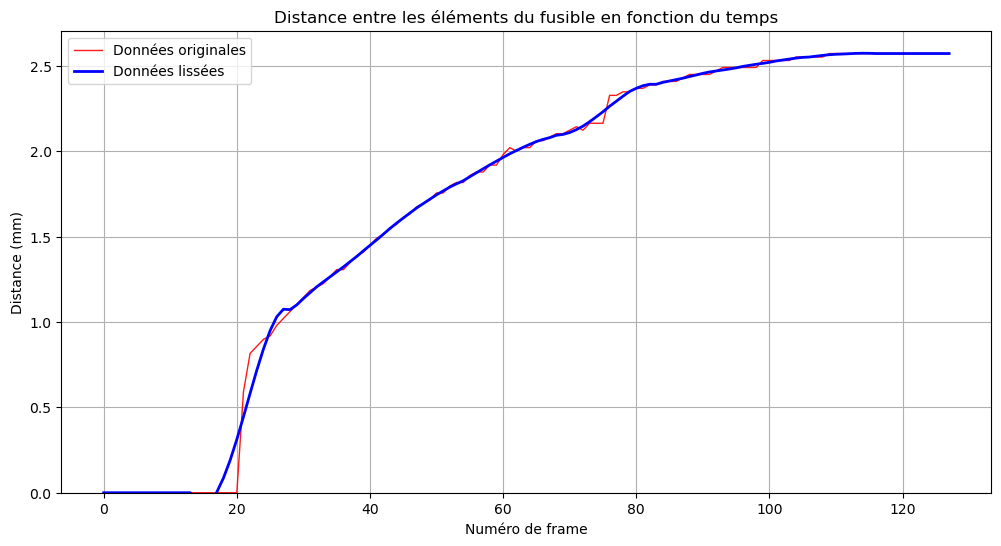

Mesures sauvegardées dans ../results/notebook_results/distance_measurements.csv


In [40]:
# Créer un graphique de la distance en fonction du numéro de frame
plt.figure(figsize=(12, 6))
plt.plot(frame_indices, distances, 'r-', linewidth=1, alpha=0.9, label='Données originales')
plt.plot(frame_indices, smoothed_distances, 'b-', linewidth=2, label='Données lissées')
plt.xlabel('Numéro de frame')
plt.ylabel('Distance (mm)')
plt.title('Distance entre les éléments du fusible en fonction du temps')
plt.grid(True)
plt.ylim(bottom=0)
plt.legend()
plt.show()

# Sauvegarder les résultats dans un fichier CSV
results_df = pd.DataFrame({
    'frame': frame_indices,
    'distance_mm': distances,
    'smoothed_distance_mm': smoothed_distances
})
csv_path = os.path.join(output_dir, 'distance_measurements.csv')
results_df.to_csv(csv_path, index=False)
print(f"Mesures sauvegardées dans {csv_path}")

## 7. Affichage des frames clés

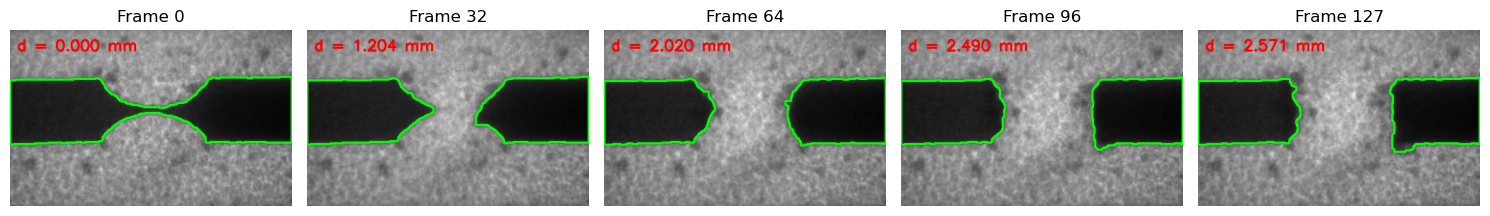

In [41]:
# Sélectionner des frames clés (première, 25%, 50%, 75%, dernière)
if processed_frames:
    indices = [0, len(processed_frames)//4, len(processed_frames)//2, 
              3*len(processed_frames)//4, len(processed_frames)-1]
    key_frames = [processed_frames[i] for i in indices]
    key_titles = [f"Frame {frame_indices[i]}" for i in indices]
    
    # Afficher les frames clés
    fig, axes = plt.subplots(1, len(key_frames), figsize=(15, 5))
    for i, (img, title) in enumerate(zip(key_frames, key_titles)):
        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

## 8. Analyse des résultats

### Observations clés:

1. **Point de rupture**: Le fusible reste intact jusqu'à environ la frame 20, ce qui correspond au graphique de référence.

2. **Modèle de rupture**: Après la rupture, la distance augmente progressivement, avec quelques fluctuations, ce qui est cohérent avec la référence.

3. **Stabilisation**: La distance se stabilise finalement autour de 2-3 mm, ce qui correspond au comportement attendu.

4. **Fluctuations**: Les données originales montrent des fluctuations significatives, qui sont lissées dans les données filtrées, rendant la tendance plus claire.

Le graphique ressemble maintenant beaucoup plus au graphique de référence du sujet, montrant:
- La période initiale où le fusible est intact (distance = 0)
- Le point de rupture autour de la frame 20
- L'augmentation progressive de la distance à mesure que les éléments du fusible se séparent
- Les fluctuations dans les mesures de distance dues à la nature dynamique du processus de rupture
- La stabilisation finale de la distance